# Stock Price Movement Prediction Using The Deutsche Börse Public Dataset & Machine Learning - Notebook 3 (Applying A Neural Network)

Here we apply the neural network approach suggested in Notebook 1 to the data set product in Notebook 2.

In [1]:
import pandas as pd
import numpy as np
import glob, os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from pandas import DataFrame
from pandas import concat

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU
from keras.layers import LSTM
from keras import regularizers

import datetime


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Added L2 penalty
- Added extra features
- Added strategy computation

We read the file we processed in the second notebook

In [2]:
input_file = '/data/processed/cooked_v3.pkl'
df = pd.read_pickle(input_file)

Checking what stocks are available in the file

In [3]:
all_mnemonics = df.Mnemonic.unique()
df.Mnemonic.unique(), df.Mnemonic.unique().shape[0]

(array(['SNH', 'DBK', 'EOAN', 'DTE', 'CBK', 'RWE', 'IFX', 'SVAB', 'LHA',
        'DAI', 'O2D', 'TKA', 'DPW', 'HDD', 'SIE', 'AIXA', 'BAYN', 'SAP',
        'BAS', 'EVT', 'AT1', 'PSM', 'BMW', 'VOW3', 'FRE', 'GAZ', 'SDF',
        'CEC', 'ALV', 'VNA', 'B4B', 'SHA', 'AB1', 'UN01', 'DLG', 'NDX1',
        'NOA3', 'IGY', 'VODI', 'ADS', '1COV', 'TUI1', 'BPE5', 'HEI', 'KCO',
        'ADV', 'SZU', 'EVK', 'HEN3', 'WDI', 'MUV2', 'DWNI', 'MRK', 'USE',
        'PAH3', 'DEZ', 'FME', 'G1A', 'FNTN', 'RKET', 'QIA', 'DB1', 'ZAL',
        'QSC', 'CON', 'SGL', 'BVB', 'TINA', 'PBB', 'PNE3', 'RIB', 'OSR',
        'SHL', 'AOX', 'BEI', 'TEG', 'UTDI', 'ARL', 'MDG1', 'KGX', 'LXS',
        'ARO', 'TTI', 'SANT', 'GYC', 'ANO', 'LINU', 'SOW', 'SZG', 'LLD',
        'BOSS', 'BNR', 'WAF', 'LIN', 'DRI', 'NDA', 'ZIL2', 'SY1', 'CAP',
        '3W9K'], dtype=object), 100)

Check what dates are available in the file. We will split the original set
into three parts, train, valid, test based on the dates.
If the dates are ordered chronologically, we take the first dates for the test set,
then we take the next dates for the validation set and finally we take what is
left for the test set

In [4]:
def date_part(dt):
    return str(dt).split(' ')[0]
unique_days = sorted(list(set(map(date_part , list(df.index.unique())))))
len(unique_days), unique_days[0:2], unique_days[-3:-1]

(200, ['2017-07-03', '2017-07-04'], ['2018-04-26', '2018-04-27'])

In [5]:
percent_train = 60.0
percent_valid = 5.0
percent_test = 100.0 - percent_train - percent_valid

offset_train = int(len(unique_days)*percent_train/100.0)
offset_test = offset_train + int(len(unique_days)*percent_valid/100.0)

train_valid_days = list(set(unique_days[0:offset_test]))

np.random.seed(484811945)
np.random.shuffle(train_valid_days)

train_days = train_valid_days[0:offset_train]
valid_days = train_valid_days[offset_train:]
test_days = set(unique_days[offset_test:])
'train', len(train_days), 'valid', len(valid_days), 'test', len(test_days)

('train', 120, 'valid', 10, 'test', 70)

In [6]:
df['CalcDateTime'] = df.index
df['Date'] = df['CalcDateTime'].dt.strftime("%Y-%m-%d")

In [7]:
df_train = df[df.Date.isin(list(train_days))]
df_valid = df[df.Date.isin(list(valid_days))]
df_test = df[df.Date.isin(list(test_days))]

We've prepared the train, test and valid sets. Make sure the days do not overlap

In [8]:
df_train[['CalcDateTime']].describe()

,CalcDateTime
count,8652000
unique,86520
top,2017-08-09 08:10:00
freq,100
first,2017-07-03 08:00:00
last,2018-01-09 20:00:00


In [9]:
df_valid[['CalcDateTime']].describe()

,CalcDateTime
count,721000
unique,7210
top,2017-12-29 15:53:00
freq,100
first,2017-07-05 08:00:00
last,2017-12-29 20:00:00


In [10]:
df_test[['CalcDateTime']].describe()

,CalcDateTime
count,5047000
unique,50470
top,2018-03-16 10:22:00
freq,100
first,2018-01-10 08:00:00
last,2018-04-30 20:00:00


In the class below we create features from the raw features

In [11]:
def clipped(ind, limit):
    return np.where(ind < -limit, -limit, np.where(ind > limit, limit, ind ))

class NARemover:
    def __init__(self, name):
        self.name = name
    def transform(self, single_stock):
        before = single_stock.shape[0]
        single_stock = single_stock.dropna()
        after = single_stock.shape[0]
        print("{}: Dropped {:2.2f} % of records due to NA".format(self.name, 100.0*(before - after)/(0.0001 + before)))
        return single_stock

class Featurizer:
    def transform(self, single_stock, max_offset = 10):
        steps = 5    
        limit = 5

        # compute a smoothed standard deviation going back 5 and 10 steps
        end_price_fixed = single_stock['EndPrice'].shift(1)
        max_price_fixed = single_stock['MaxPrice'].shift(1)
        min_price_fixed = single_stock['MinPrice'].shift(1)        

        end_price_fixed = single_stock['EndPrice'].shift(1)
        stds = 0.000001 + 0.9 * end_price_fixed.rolling(steps).std() + 0.1*end_price_fixed.rolling(10).std()

        single_stock['x(NormalizingStd)'] = stds
        
        for offset in range(1, max_offset + 1):
            # take the end price in the past at (t - offset)
            end_price = single_stock['EndPrice'].shift(offset)

            # take the max price in the past at (t - offset)        
            min_price = single_stock['MinPrice'].shift(offset)

            # take the min price in the past at (t - offset)
            max_price = single_stock['MaxPrice'].shift(offset)
        
            # compute an indicator for time (t - offset)
            ind = ((max_price - end_price) - (end_price - min_price)) / stds
            single_stock['x((MaxP-EndP)-(EndP-MinP))(t - {})'.format(str(offset))] = clipped(ind, limit)   
        
            ind = (max_price - end_price) / stds
            single_stock['x(MaxP - EndP)(t - {})'.format(str(offset))] = clipped(ind, limit)       
        
            ind = (end_price - min_price) / stds
            single_stock['x(EndP-MinP)(t - {})'.format(str(offset))] = clipped(ind, limit)  
                
            ind = (end_price - end_price_fixed) / stds
            single_stock['x(EndP-EndPBase)(t - {})'.format(str(offset))] = clipped(ind, limit)  
                
            ind = (max_price - max_price_fixed) / stds
            single_stock['x(MaxP-MaxPBase)(t - {})'.format(str(offset))] = clipped(ind, limit) 
              
            ind = (min_price - min_price_fixed) / stds
            single_stock['x(MinP-MinPBase)(t - {})'.format(str(offset))] = clipped(ind, limit)              
        
        end_price_0 = single_stock['EndPrice'].shift(1)
        for offset in range(2, max_offset):
            end_price_1 = single_stock['EndPrice'].shift(offset + 1)             
            ind = (end_price_0 - end_price_1) / stds
            single_stock['x(EndP)(t - {}, t - {})'.format(str(1), str(offset + 1))] = \
                clipped(ind, limit)  
             
        for offset in range(2, max_offset):
            end_price_1 = single_stock['EndPrice'].shift(offset + 1)             
            single_stock['x(CombinedP)(t - {}, t - {})'.format(str(1), str(offset + 1))] = \
                single_stock['x(EndP)(t - {}, t - {})'.format(str(1), str(offset + 1))] * \
                single_stock['x((MaxP-EndP)-(EndP-MinP))(t - {})'.format(str(offset))]
              
        for offset in range(1, max_offset):
            # take the end price in the past at (t - offset)
            end_price = single_stock['EndPrice'].shift(offset)
            end_price_1 = single_stock['EndPrice'].shift(offset + 1)  

            # take the max price in the past at (t - offset)        
            min_price = single_stock['MinPrice'].shift(offset)
            min_price_1 = single_stock['MinPrice'].shift(offset + 1)

            # take the min price in the past at (t - offset)
            max_price = single_stock['MaxPrice'].shift(offset)
            max_price_1 = single_stock['MaxPrice'].shift(offset + 1)            
            
            ind = (max_price - end_price_1) - (end_price_1 - min_price) / stds
            single_stock['x((MaxP-EndP[-1])-(EndP-MinP[-1]))(t - {})'.format(str(offset))] = clipped(ind, limit)  
            
            ind = (max_price - end_price_1) - (max_price - end_price_1) / stds
            single_stock['x(f1)(t - {})'.format(str(offset))] = clipped(ind, limit)  

            ind = (min_price - end_price_1) - (min_price - end_price_1) / stds
            single_stock['x(f2)(t - {})'.format(str(offset))] = clipped(ind, limit)
            
           
            ind = (max_price - end_price) - (max_price_1 - end_price) / stds
            single_stock['x(f3)(t - {})'.format(str(offset))] = clipped(ind, limit)  

            ind = (min_price - end_price) - (min_price_1 - end_price) / stds
            single_stock['x(f4)(t - {})'.format(str(offset))] = clipped(ind, limit)
            
        single_stock['y(Return)'] = (single_stock['EndPrice'] - single_stock['EndPrice'].shift(1))
        ret = single_stock['y(Return)']/stds
        single_stock['pseudo_y(ClippedReturn)'] = clipped(ret, limit) 
        single_stock['pseudo_y(SignReturn)'] = np.sign(single_stock['y(Return)'])
        
        # for evaluation we should use pct change
        prev = single_stock['EndPrice'].shift(1)
        single_stock['pseudo_y(pctChange)'] = (single_stock['EndPrice'] - prev)/prev
        return single_stock

The variable we use for predictions start with `x(`, while the variables that should be predicted start with `y(`

In [12]:
dummy = df_train[df_train.Mnemonic == 'BMW'].copy()
dummy = dummy[dummy.HasTrade == 1.0].iloc[100:111]
Featurizer().transform(dummy)
old = dummy.iloc[[-1]].copy()
old

,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,HasTrade,TradedVolume,NumberOfTrades,CalcDateTime,Date,...,x(f4)(t - 8),x((MaxP-EndP[-1])-(EndP-MinP[-1]))(t - 9),x(f1)(t - 9),x(f2)(t - 9),x(f3)(t - 9),x(f4)(t - 9),y(Return),pseudo_y(ClippedReturn),pseudo_y(SignReturn),pseudo_y(pctChange)
CalcDateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-03 09:51:00,BMW,82.34,82.36,82.34,82.34,1.0,2163.0,30.0,2017-07-03 09:51:00,2017-07-03,...,0.987222,-3.051665,0.0,3.021665,-3.031665,-1.027222,0.01,1.017222,1.0,0.000121


In [13]:
dummy.ix[ -1, 'MinPrice'] = 0.0
dummy.ix[ -1, 'MaxPrice'] = 0.0
dummy.ix[ -1, 'EndPrice'] = 0.0


Featurizer().transform(dummy)
dummy.iloc[[-1]]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,HasTrade,TradedVolume,NumberOfTrades,CalcDateTime,Date,...,x(f4)(t - 8),x((MaxP-EndP[-1])-(EndP-MinP[-1]))(t - 9),x(f1)(t - 9),x(f2)(t - 9),x(f3)(t - 9),x(f4)(t - 9),y(Return),pseudo_y(ClippedReturn),pseudo_y(SignReturn),pseudo_y(pctChange)
CalcDateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-03 09:51:00,BMW,0.0,0.0,82.34,0.0,1.0,2163.0,30.0,2017-07-03 09:51:00,2017-07-03,...,0.987222,-3.051665,0.0,3.021665,-3.031665,-1.027222,-82.33,-5.0,-1.0,-1.0


Make sure old features and new features computed with different values of EndPrice, MaxPrice, MinPrice of the last
record give the same values for the `x(` features

In [14]:
for f in dummy.dtypes.index:
    if f.startswith('x('):
        assert dummy[f][-1] == old[f][0]

In [15]:
class TrainingSet:
    def __init__(self, X, y, orig_df):
        self.X = X
        self.y = y
        self.original_df = orig_df
        
class TrainingSetBuilder:
    def transform(self, single_stock):
        x_features = filter(lambda name: name.startswith('x('), list(single_stock.dtypes.index))
        X = single_stock[x_features].values
        y = single_stock[['pseudo_y(SignReturn)']].values
        return TrainingSet(X, y, single_stock)

In [16]:
class Predictions:
    def __init__(self, predictions, training_set):

        self.predictions = predictions
        self.training_set = training_set
        
    def evaluate(self):
        single_feature = 'x((MaxP-EndP)-(EndP-MinP))(t - 1)'
        stats_df = pd.DataFrame({
                      'predictions': self.predictions[:,0],
                      'single_feature_pred': self.training_set.original_df[single_feature].values,
                      'pseudo_y(SignReturn)': self.training_set.y[:,0],
                      'pseudo_y(pctChange)': self.training_set.original_df['pseudo_y(pctChange)'].values,
                       'pseudo_y(ClippedReturn)': self.training_set.original_df['pseudo_y(ClippedReturn)'].values,
                      'y(Return)': self.training_set.original_df['y(Return)'].values})
        
        corr = stats_df. \
            corr()[['predictions', 'single_feature_pred']]. \
            iloc[1:]
            
        pred_signs = np.sign(stats_df['predictions'])
        y_signs = np.sign(stats_df['y(Return)'])
        has_answer = np.absolute(pred_signs * y_signs).sum()
        correct = np.where(pred_signs * y_signs == 1.0, 1.0, 0.0).sum()
        
        thresholds = []
        accuracy = []
        correct_lst = []
        errors = []
        percent_has_answer = []
        abs_has_answer = []
        achieved_returns = []

        preds = stats_df['predictions']
        
        for d in range(5, 46, 5):
            low = np.percentile(preds, d) 
            high = np.percentile(preds, 100 - d)
            thresholded = np.where(preds > high, 1.0, np.where(preds < low, -1.0, 0.0))
            c = np.where(np.sign(thresholded)*np.sign(y_signs) == 1.0, 1.0, 0.0).sum()
            e = np.where(np.sign(thresholded)*np.sign(y_signs) == -1.0, 1.0, 0.0).sum()
            achieved_ret = (stats_df['pseudo_y(pctChange)']*thresholded).sum()
            correct_lst.append(c)
            errors.append(e)
            accuracy.append(c/(c + e))
            percent_has_answer.append(100.0*(c + e)/pred_signs.shape[0])
            abs_has_answer.append((c + e))
            achieved_returns.append(achieved_ret)
            thresholds.append(d)
            
        at_cutoff = DataFrame({
                    'thresholds': thresholds,
                    'accuracy': accuracy,
                    'percent_with_answer': percent_has_answer,
                    'absolute_has_answer': abs_has_answer,
                    'achieved_returns': achieved_returns,
                    'correct': correct_lst,
                    'errors': errors
        })
        at_cutoff['achieved_norm_returns'] = at_cutoff['achieved_returns']/at_cutoff['absolute_has_answer']
        
        ret = stats_df['pseudo_y(pctChange)']
        rand_feature = np.where(np.random.rand(ret.shape[0]) > 0.5, 1.0, -1.0)    
        random_returns = (ret * rand_feature).sum()
        always_up_returns = (ret*1.0).sum()
        always_down_returns = (ret*-1.0).sum()
        omnicient_returns = (np.absolute(ret)).sum()
        achieved = (ret * pred_signs).sum()
        return {
            'corr': corr,
            'accuracy_at_cutoff': at_cutoff,
            'matches': {
                'percent_correct': 100*correct/has_answer,
                'percent_has_answer': has_answer/pred_signs.shape[0],
                'absolute_with_answer': has_answer,
                'size': pred_signs.shape[0]
            },
            'strategies': {
                'omniscient': omnicient_returns,
                'random': random_returns,
                'always_up': always_up_returns,
                'always_down': always_down_returns,
                'achieved': achieved,
                'num_trials': np.absolute(pred_signs).sum()
            }
        }
    
class MLModel:
    def __init__(self):
        self.model = None
        
    def fit(self, training_set, valid_set = None):
        train_X, train_y = training_set.X, training_set.y
        
        if valid_set is None:
            valid_X, valid_y = train_X, train_y
        else:
            valid_X, valid_y = valid_set.X, valid_set.y

        model = Sequential()

        model.add(Dense(100, activation='relu', input_shape =(train_X.shape[1],),
                        kernel_regularizer=regularizers.l2(0.001))) 
        model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))        

        model.add(Dense(1))
        
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.model = model            

        # fit network
        # change the epochs back to 20
        history = model.fit(train_X, train_y, epochs=50, batch_size=2500, validation_data=(valid_X, valid_y), verbose=2, shuffle=True)
        # plot history
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='valid')
        pyplot.legend()
        pyplot.show()
        
    def transform(self, input_set):
        predictions = self.model.predict(input_set.X)
        return Predictions(predictions, input_set)
    
    def fit_transform(self, training_set, valid_set):
        self.fit(training_set, valid_set)
        return self.transform(training_set), self.transform(valid_set)

SNH: Dropped 0.02 % of records due to NA
(43080, 136)
SNH: Dropped 0.29 % of records due to NA
SNH: Dropped 0.04 % of records due to NA
DBK: Dropped 0.02 % of records due to NA
(54629, 136)
DBK: Dropped 0.23 % of records due to NA
DBK: Dropped 0.03 % of records due to NA
EOAN: Dropped 0.02 % of records due to NA
(54570, 136)
EOAN: Dropped 0.23 % of records due to NA
EOAN: Dropped 0.03 % of records due to NA
DTE: Dropped 0.02 % of records due to NA
(51751, 136)
DTE: Dropped 0.24 % of records due to NA
DTE: Dropped 0.03 % of records due to NA
CBK: Dropped 0.02 % of records due to NA
(52433, 136)
CBK: Dropped 0.25 % of records due to NA
CBK: Dropped 0.03 % of records due to NA
RWE: Dropped 0.02 % of records due to NA
(52128, 136)
RWE: Dropped 0.24 % of records due to NA
RWE: Dropped 0.03 % of records due to NA
IFX: Dropped 0.02 % of records due to NA
(52194, 136)
IFX: Dropped 0.24 % of records due to NA
IFX: Dropped 0.03 % of records due to NA
SVAB: Dropped 0.19 % of records due to NA
(52

QIA: Dropped 0.03 % of records due to NA
(33737, 136)
QIA: Dropped 0.40 % of records due to NA
QIA: Dropped 0.05 % of records due to NA
DB1: Dropped 0.02 % of records due to NA
(49103, 136)
DB1: Dropped 0.25 % of records due to NA
DB1: Dropped 0.04 % of records due to NA
ZAL: Dropped 0.02 % of records due to NA
(41253, 136)
ZAL: Dropped 0.30 % of records due to NA
ZAL: Dropped 0.04 % of records due to NA
QSC: Dropped 0.10 % of records due to NA
(9595, 136)
QSC: Dropped 1.32 % of records due to NA
QSC: Dropped 0.29 % of records due to NA
CON: Dropped 0.02 % of records due to NA
(49654, 136)
CON: Dropped 0.26 % of records due to NA
CON: Dropped 0.03 % of records due to NA
SGL: Dropped 0.04 % of records due to NA
(23599, 136)
SGL: Dropped 0.55 % of records due to NA
SGL: Dropped 0.09 % of records due to NA
BVB: Dropped 0.05 % of records due to NA
(18209, 136)
BVB: Dropped 0.81 % of records due to NA
BVB: Dropped 0.10 % of records due to NA
TINA: Dropped 0.13 % of records due to NA
(7575, 

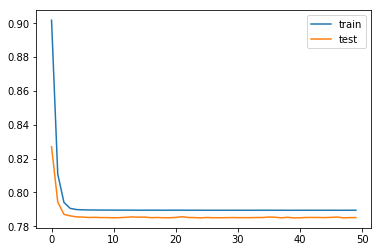

In [17]:
combined_training_set = []
combined_valid_set = []
combined_test_set = []

for mnemonic in all_mnemonics: #['SIE', 'BMW', 'SNH', 'DBK', 'EOAN',  'DTE', 'CBK', 'RWE', 'IFX']:

    single_stock = df_train[df_train.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0]
    single_stock = Featurizer().transform(single_stock)
    single_stock = NARemover(mnemonic).transform(single_stock)
    combined_training_set.append(single_stock)
    print(single_stock.shape)

    single_stock = df_valid[df_valid.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0] 
    single_stock = Featurizer().transform(single_stock)
    single_stock = NARemover(mnemonic).transform(single_stock)
    combined_valid_set.append(single_stock)
    
    single_stock = df_test[df_test.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0] 
    single_stock = Featurizer().transform(single_stock)
    single_stock = NARemover(mnemonic).transform(single_stock)
    combined_test_set.append(single_stock)
    
combined_training_set_df = pd.concat(combined_training_set, axis=0)
training_set = TrainingSetBuilder().transform(combined_training_set_df)
    
combined_valid_set_df = pd.concat(combined_valid_set, axis=0)
valid_set = TrainingSetBuilder().transform(combined_valid_set_df) 

combined_test_set_df = pd.concat(combined_test_set, axis=0)
test_set = TrainingSetBuilder().transform(combined_test_set_df) 
    
model = MLModel()
train_predictions, valid_predictions = model.fit_transform(training_set, valid_set)


In [18]:
train_predictions.evaluate()['matches']

{'absolute_with_answer': 2700262.0,
 'percent_correct': 53.93484039696889,
 'percent_has_answer': 0.7948144273667498,
 'size': 3397349}

In [19]:
valid_predictions.evaluate()['matches']

{'absolute_with_answer': 209181.0,
 'percent_correct': 53.83471730224064,
 'percent_has_answer': 0.7899763589809436,
 'size': 264794}

In [20]:
test_predictions = model.transform(test_set)
test_predictions.evaluate()['matches']

{'absolute_with_answer': 1662337.0,
 'percent_correct': 53.5093064763643,
 'percent_has_answer': 0.7810295283951453,
 'size': 2128392}

In [21]:
train_predictions.evaluate()['accuracy_at_cutoff']

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,267937.0,0.597517,115.067683,160097.0,107840.0,7.886649,5,0.000429
1,537230.0,0.584169,178.481673,313833.0,223397.0,15.813212,10,0.000332
2,807813.0,0.575225,227.250309,464674.0,343139.0,23.777746,15,0.000281
3,1079270.0,0.568268,262.329637,613315.0,465955.0,31.768005,20,0.000243
4,1351000.0,0.561947,289.974632,759191.0,591809.0,39.766300,25,0.000215
5,1622200.0,0.556761,314.370359,903178.0,719022.0,47.748995,30,0.000194
6,1892992.0,0.551755,337.534825,1044468.0,848524.0,55.719680,35,0.000178
7,2162466.0,0.547523,352.966457,1184000.0,978466.0,63.651571,40,0.000163
8,2431481.0,0.543373,364.691663,1321202.0,1110279.0,71.569951,45,0.000150


In [22]:
def pred_baseline(d):
    single_feature = 'x((MaxP-EndP)-(EndP-MinP))(t - 1)'
    preds = d.training_set.original_df[single_feature].values
    preds = preds.reshape((preds.shape[0], 1))
    return Predictions(preds, d.training_set).evaluate()

def readable_summary(which_set, p):
    achieved = p.evaluate()['strategies']['achieved']
    achieved_baseline = pred_baseline(p)['strategies']['achieved']
    per_change = np.mean(np.absolute(p.training_set.original_df['pseudo_y(pctChange)']))
    n = p.training_set.original_df.shape[0]
    print ("""So if you play {} times on the {} with 1 EUR and you always guess the movement,
ignoring all transactions cost, you will make {}. 
Instead you make {} or {} percent of the ideally achievable.
If you use the baseline you will make {} or {} percent of ideal""".format(
        n, which_set, n * per_change, achieved, 100.0*achieved/(n*per_change),
          achieved_baseline, 100.0*achieved_baseline/(n*per_change)))
readable_summary('Training Set', train_predictions)

So if you play 3397349 times on the Training Set with 1 EUR and you always guess the movement,
ignoring all transactions cost, you will make 2191.20627456. 
Instead you make 371.468652327 or 16.9527011966 percent of the ideally achievable.
If you use the baseline you will make 156.787598049 or 7.15530983409 percent of ideal


In [23]:
train_predictions.evaluate()['strategies']

{'achieved': 371.4686523273236,
 'always_down': -36.53431596652022,
 'always_up': 36.53431596652022,
 'num_trials': 3397349.0,
 'omniscient': 2191.206274564835,
 'random': 0.37983003012628735}

In [24]:
pred_baseline(valid_predictions)['strategies'] 

{'achieved': 10.300250300757304,
 'always_down': -16.120621322692667,
 'always_up': 16.120621322692667,
 'num_trials': 175315.0,
 'omniscient': 201.38785391708964,
 'random': 7.49194215978099}

In [25]:
valid_predictions.evaluate()['accuracy_at_cutoff']

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,20696.0,0.593158,4.859130,12276.0,8420.0,7.815887,5,0.000235
1,41537.0,0.579170,8.765475,24057.0,17480.0,15.686534,10,0.000211
2,62395.0,0.572209,11.851657,35703.0,26692.0,23.563600,15,0.000190
3,83407.0,0.564605,13.683131,47092.0,36315.0,31.498826,20,0.000164
4,104389.0,0.558814,16.520182,58334.0,46055.0,39.422721,25,0.000158
5,125342.0,0.553980,17.181956,69437.0,55905.0,47.335665,30,0.000137
6,146367.0,0.549632,30.192079,80448.0,65919.0,55.275799,35,0.000206
7,167318.0,0.545393,30.687667,91254.0,76064.0,63.187988,40,0.000183
8,188275.0,0.541968,31.225679,102039.0,86236.0,71.102442,45,0.000166


### Baseline on Testset: Accuracy at different levels

In [26]:
# this is for the baseline
pred_baseline(test_predictions)['accuracy_at_cutoff'] 

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,168159.0,0.567487,34.145246,95428.0,72731.0,7.900753,5,0.000203
1,338247.0,0.560859,55.956382,189709.0,148538.0,15.892138,10,0.000165
2,507052.0,0.555728,73.317496,281783.0,225269.0,23.823243,15,0.000145
3,676940.0,0.550663,87.090783,372766.0,304174.0,31.805231,20,0.000129
4,848942.0,0.545472,97.624355,463074.0,385868.0,39.886543,25,0.000115
5,1026028.0,0.540843,102.612630,554920.0,471108.0,48.206721,30,0.000100
6,1160196.0,0.536681,99.225102,622655.0,537541.0,54.510447,35,0.000086
7,1160196.0,0.536681,99.225102,622655.0,537541.0,54.510447,40,0.000086
8,1160196.0,0.536681,99.225102,622655.0,537541.0,54.510447,45,0.000086


### Baseline on Testset: Comparison of Returns

In [27]:
# this is for the baseline
pred_baseline(test_predictions)['strategies']

{'achieved': 99.22510172088424,
 'always_down': -2.8184952097059814,
 'always_up': 2.8184952097059814,
 'num_trials': 1436174.0,
 'omniscient': 1638.5998374293326,
 'random': -6.32069528321988}

### ML Model on Testset: Accuracy at different levels

In [28]:
# this is for ML
test_predictions.evaluate()['accuracy_at_cutoff']

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,164730.0,0.588035,72.068937,96867.0,67863.0,7.739646,5,0.000437
1,330183.0,0.575554,115.657145,190038.0,140145.0,15.513261,10,0.000350
2,496976.0,0.566679,148.828014,281626.0,215350.0,23.349834,15,0.000299
3,664073.0,0.560366,173.802069,372124.0,291949.0,31.200690,20,0.000262
4,831629.0,0.555227,193.864521,461743.0,369886.0,39.073112,25,0.000233
5,999001.0,0.550809,211.609139,550259.0,448742.0,46.936889,30,0.000212
6,1165834.0,0.546665,223.401865,637321.0,528513.0,54.775342,35,0.000192
7,1331767.0,0.542870,233.593762,722976.0,608791.0,62.571509,40,0.000175
8,1497333.0,0.539412,239.141232,807680.0,689653.0,70.350434,45,0.000160


### ML Model on Testset: Comparison of Returns

In [29]:
# for ML
Predictions(test_predictions.predictions, test_predictions.training_set).evaluate()['strategies']

{'achieved': 238.0119688885496,
 'always_down': -2.8184952097059814,
 'always_up': 2.8184952097059814,
 'num_trials': 2128392.0,
 'omniscient': 1638.5998374293326,
 'random': 1.3535557596882493}

In [31]:
readable_summary('Test set', test_predictions)

So if you play 2128392 times on the Test set with 1 EUR and you always guess the movement,
ignoring all transactions cost, you will make 1638.59983743. 
Instead you make 238.011968889 or 14.5253260407 percent of the ideally achievable.
If you use the baseline you will make 99.2251017209 or 6.05548099386 percent of ideal


### Analysis by Mnemonic and by Date

It is known that when it comes to stock predictions, different stocks and different days will exibit different performance

In [153]:
def plot_accuracy_by(grouping_feature, predictions):
    df = predictions.training_set.original_df
    s = df[['Date', 'Mnemonic', 'pseudo_y(SignReturn)']].copy()
    s['Predictions'] = predictions.predictions
    s['Baseline'] = df['x((MaxP-EndP)-(EndP-MinP))(t - 1)']

    def agg(group):
        pred = group['Predictions']
        baseline = group['Baseline']
        rets = group['pseudo_y(SignReturn)']
        c = pred.corr(rets)
        c = np.where(np.sign(pred)*np.sign(rets) == 1.0, 1.0, 0.0).sum()
        e = np.where(np.sign(pred)*np.sign(rets) == -1.0, 1.0, 0.0).sum()
        acc = c/(c + e)

        c_baseline = np.where(np.sign(baseline)*np.sign(rets) == 1.0, 1.0, 0.0).sum()
        e_baseline = np.where(np.sign(baseline)*np.sign(rets) == -1.0, 1.0, 0.0).sum()
        acc_baseline = c_baseline/(c_baseline + e_baseline)

        l = group.shape[0]
        return {"corr": c, 'size': l, 'accuracy': acc, 'acc_baseline': acc_baseline}
    f = s.groupby(grouping_feature).apply(agg).to_frame("agg")

    f['AccuracyPred'] = f['agg'].map(lambda i: i['accuracy'])
    f['AccuracyBaseline'] = f['agg'].map(lambda i: i['acc_baseline'])
    f['AccPred - AccBaseline'] = f['AccuracyPred'] - f['AccuracyBaseline']
    f = f.drop(columns=['agg'])

    f = f[f.index != '2017-10-14'] # remove this date which has one data point
    f[['AccuracyPred', 'AccuracyBaseline']].plot()
    return f

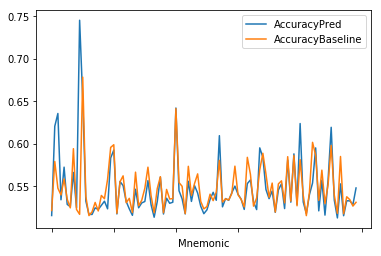

In [154]:
perf = plot_accuracy_by('Mnemonic', test_predictions)

In [155]:
perf.sort_values(by='AccuracyPred', ascending=False).head(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Mnemonic,,,
ARO,0.745455,0.517241,0.228213
AT1,0.652975,0.678565,-0.025589
GAZ,0.642234,0.641590,0.000644
AB1,0.635802,0.547945,0.087857
SVAB,0.623996,0.581560,0.042436
3W9K,0.620773,0.579365,0.041408
USE,0.619565,0.598214,0.021351
MDG1,0.609740,0.580709,0.029031
QSC,0.595390,0.569677,0.025713


In [156]:
perf.sort_values(by='AccuracyPred', ascending=False).tail(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Mnemonic,,,
DB1,0.523620,0.536047,-0.012426
PAH3,0.523028,0.525957,-0.002929
BMW,0.522967,0.521218,0.001749
QIA,0.522816,0.536484,-0.013669
LIN,0.522549,0.526406,-0.003857
TKA,0.521335,0.533668,-0.012333
SAP,0.519582,0.519968,-0.000386
SZG,0.518228,0.515717,0.002511
LHA,0.517990,0.523647,-0.005657


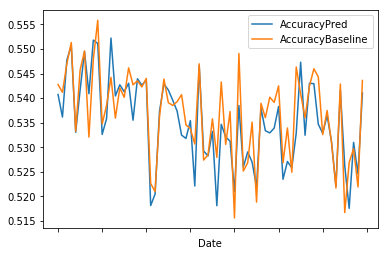

In [158]:
perf = plot_accuracy_by('Date', test_predictions)

In [159]:
perf.sort_values(by='AccuracyPred', ascending=False).head(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Date,,,
2018-01-26,0.552227,0.544215,0.008011
2018-01-22,0.551807,0.547880,0.003927
2018-01-23,0.551116,0.555849,-0.004733
2018-01-15,0.550708,0.551314,-0.000606
2018-01-18,0.549494,0.549597,-0.000102
2018-01-12,0.547754,0.547022,0.000732
2018-04-10,0.547308,0.540861,0.006448
2018-02-23,0.546640,0.546975,-0.000335
2018-02-05,0.543933,0.543524,0.000408


In [160]:
perf.sort_values(by='AccuracyPred', ascending=False).tail(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Date,,,
2018-04-19,0.531091,0.530912,0.000179
2018-04-26,0.530988,0.529704,0.001284
2018-02-26,0.529216,0.527383,0.001833
2018-03-12,0.529037,0.526849,0.002188
2018-02-27,0.528221,0.528449,-0.000228
2018-03-23,0.527086,0.533920,-0.006833
2018-03-13,0.526939,0.535091,-0.008153
2018-04-24,0.526151,0.516694,0.009457
2018-03-09,0.525953,0.525134,0.000818
